# Trustpilot Reviews Analysis: Customer Sentiment and Topic Modeling

## Introduction

This workbook provides a comprehensive analysis of customer reviews from Trustpilot, examining customer sentiment and identifying key topics of discussion across various businesses. Using natural language processing techniques implemented with PySpark, the analysis extracts valuable insights from over 123,000 customer reviews to understand customer satisfaction drivers and pain points.

## Context

The project analyzes data from the trustpilot_reviews_2005.csv dataset, which contains reviews across 22 different business categories and 1,680 companies. Each review includes information such as the review text, star rating (1-5), company name, category, and description.

The analysis follows a structured approach:

- Data loading and preprocessing with PySpark
- Exploratory data analysis to understand review distributions
- Text preprocessing including tokenization and stopword removal
- Topic modeling using Latent Dirichlet Allocation (LDA) to identify key themes
- Sentiment analysis using VADER (or a fallback lexicon-based approach) to quantify review sentiment
- Visualization and interpretation of topic-sentiment relationships

## Key Findings

The analysis identified seven distinct topics in customer reviews:

- Product Quality - Discussion about the quality, durability and condition of products (30,982 reviews)
- Billing - Comments related to payments, charges, refunds and pricing structures (25,593 reviews)
- General Feedback - Overall satisfaction and recommendations (16,948 reviews)
- User Experience - Comments about ease of use, interface, and customer journey (15,155 reviews)
- Delivery - Feedback on shipping, packaging, and timing (13,156 reviews)
- Customer Service - Mentions of support quality, responsiveness, and issue resolution (12,807 reviews)
- Price - Specific discussion of cost and value (8,540 reviews)
- Sentiment analysis revealed that "Billing" topics have the highest average sentiment score (0.706), while "Product Quality" has the lowest (-0.072), suggesting customers are most satisfied with payment processes but most critical about product quality issues.

The distribution of star ratings shows a slight U-shape pattern, with higher frequencies of 1-star reviews (24,065) and 5-star reviews (32,152), indicating a polarization in customer experiences.

## Summary

This analysis provides businesses with actionable insights into customer sentiment across different operational aspects. The combination of topic modeling and sentiment analysis creates a powerful framework for identifying areas of excellence and opportunities for improvement. Businesses can use these insights to prioritize improvement initiatives, better understand customer needs, and develop more effective customer experience strategies.

The methodology employed demonstrates the power of PySpark for processing and analyzing large volumes of text data efficiently, with techniques that can be applied to similar datasets for ongoing customer feedback analysis.

In [1]:
# Initialisation steps for PySpark
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("TextAnalyser") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "2") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.default.parallelism", "4") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to reduce verbose output
spark.sparkContext.setLogLevel("WARN")

# Verify the Spark session
print(f"Spark Version: {spark.version}")
print(f"Spark Application ID: {spark.sparkContext.applicationId}")

25/03/13 22:06:39 WARN Utils: Your hostname, Aarons-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.111 instead (on interface en0)
25/03/13 22:06:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/13 22:06:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Version: 3.5.5
Spark Application ID: local-1741903599963


In [8]:
!unzip ../data/trustpilot_reviews_2005.csv.zip  -d ../data

Archive:  ../data/trustpilot_reviews_2005.csv.zip
  inflating: ../data/trustpilot_reviews_2005.csv  
  inflating: ../data/__MACOSX/._trustpilot_reviews_2005.csv  


In [2]:
# Data Loading
# Read CSV file from data folder
df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("multiLine", "true") \
    .option("escape", "\"") \
    .option("quote", "\"") \
    .option("ignoreLeadingWhiteSpace", "true") \
    .option("ignoreTrailingWhiteSpace", "true") \
    .load("../data/trustpilot_reviews_2005.csv")

# Show the first few rows
df.show(5)

# Print the schema
df.printSchema()

+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|      category|             company|         description|               title|              review|stars|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
|Animals & Pets|ruffandtumbledogc...|At Ruff and Tumbl...|Great quality dog...|Great quality dog...|    5|
|Animals & Pets|ruffandtumbledogc...|At Ruff and Tumbl...|Really prompt ser...|Really prompt ser...|    5|
|Animals & Pets|ruffandtumbledogc...|At Ruff and Tumbl...|          Life saver|I’ve purchased fi...|    5|
|Animals & Pets|ruffandtumbledogc...|At Ruff and Tumbl...|     Brilliant coats|Brilliant coats. ...|    5|
|Animals & Pets|ruffandtumbledogc...|At Ruff and Tumbl...|Great company and...|Great company and...|    5|
+--------------+--------------------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows

root
 |-- ca

In [3]:
df.describe().show()
print(f"Number of partitions: {df.rdd.getNumPartitions()}")
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
df.explain()

25/03/13 22:06:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+
|summary|            category|          company|         description|               title|              review|             stars|
+-------+--------------------+-----------------+--------------------+--------------------+--------------------+------------------+
|  count|              123181|           123181|              123088|              123181|              123181|            123181|
|   mean|                NULL|             NULL|                NULL|  3443244.8000040003|        1.95931229E9|3.1826580397950983|
| stddev|                NULL|             NULL|                NULL|   5839827.519896443|                NULL|1.4707689076166997|
|    min|      Animals & Pets|101petexpress.com|\tWith over 21,00...|\nFormer student,...|              The...|                 1|
|    max|Vehicles & Transp...|         zopa.com|👋 Welcome to Lov...|            🤬🤬🤬

In [4]:
# Figure out how many partitions are required
# A general rule of thumb is to aim for partitions that are between 128 MB and 256 MB in size.
total_size_bytes = df.rdd.map(lambda row: len(str(row))).sum()
print(f"Total size of DataFrame: {total_size_bytes / (1024 * 1024):.2f} MB")

optimal_partitions = 8
df = df.repartition(optimal_partitions)



Total size of DataFrame: 131.89 MB


In [5]:
# Exploratory Data Analysis
from pyspark.sql.functions import col, length, avg, min, max, stddev

def profile_spark_df(df):
    # Rest of the code remains the same
    profile_data = []
    
    for column in df.columns:
        null_count = df.filter(col(column).isNull()).count()
        distinct_count = df.select(column).distinct().count()
        
        stats = {
            'column_name': column,
            'null_count': null_count,
            'distinct_count': distinct_count,
            'data_type': str(df.schema[column].dataType)
        }
        
        if str(df.schema[column].dataType) == 'StringType':
            text_stats = df.select(
                avg(length(column)).alias('avg_length'),
                min(length(column)).alias('min_length'),
                max(length(column)).alias('max_length'),
                stddev(length(column)).alias('stddev_length')
            ).collect()[0]
            
            stats.update({
                'avg_length': float(text_stats.avg_length),
                'min_length': int(text_stats.min_length),
                'max_length': int(text_stats.max_length),
                'stddev_length': float(text_stats.stddev_length)
            })
        
        profile_data.append(stats)
    
    profile_df = spark.createDataFrame(profile_data)
    return profile_df

profile_summary = profile_spark_df(df)
profile_summary.show(truncate=False)


+-----------+-------------+--------------+----------+
|column_name|data_type    |distinct_count|null_count|
+-----------+-------------+--------------+----------+
|category   |StringType() |22            |0         |
|company    |StringType() |1680          |0         |
|description|StringType() |1680          |93        |
|title      |StringType() |109852        |0         |
|review     |StringType() |123176        |0         |
|stars      |IntegerType()|5             |0         |
+-----------+-------------+--------------+----------+



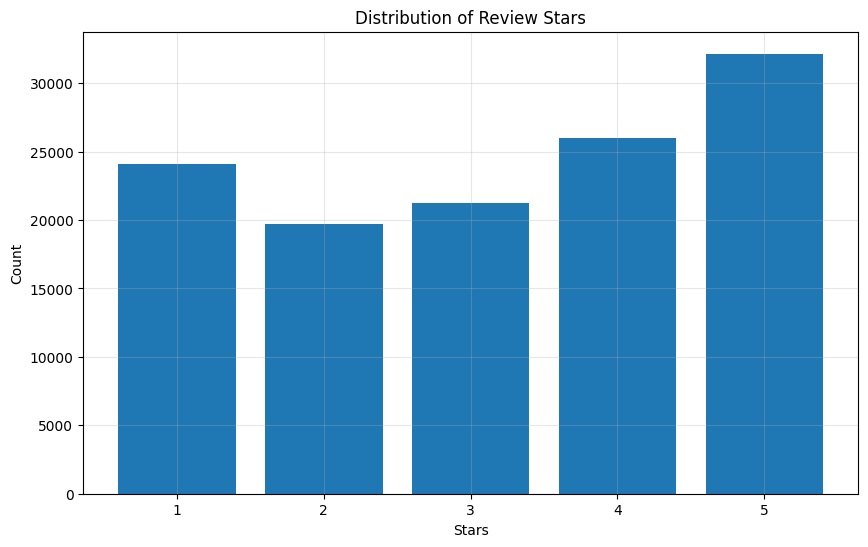

+-----+-----+
|stars|count|
+-----+-----+
|    1|24065|
|    2|19687|
|    3|21264|
|    4|26013|
|    5|32152|
+-----+-----+



In [6]:
from matplotlib import pyplot as plt
from pyspark.sql.functions import count

# Check the stars has no issues
stars_dist = df.groupBy("stars").agg(count("*").alias("count")).orderBy("stars")

# Convert to pandas only for plotting (more efficient for visualization)
stars_dist_pd = stars_dist.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(stars_dist_pd['stars'], stars_dist_pd['count'])
plt.title('Distribution of Review Stars')
plt.xlabel('Stars')
plt.ylabel('Count')
plt.xticks(stars_dist_pd['stars'])
plt.grid(True, alpha=0.3)
plt.show()

# Show the numerical distribution using Spark
stars_dist.show()

In [7]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf, col, array, explode, lit
from pyspark.sql.types import FloatType, StringType, ArrayType, IntegerType
from pyspark.ml.feature import HashingTF, Tokenizer

def analyze_with_spark_ml(df, num_topics=7):
    """
    Process text data using Spark ML library for sentiment analysis and topic modeling
    
    Args:
        df: Spark DataFrame containing a 'review' column with text data
        num_topics: Number of topics to identify (default: 7)
        
    Returns:
        DataFrame with review text, sentiment scores, and assigned topics
    """
    print("Starting analysis using Spark ML...")
    
    # =====================================================================
    # 1. TEXT PREPROCESSING
    # =====================================================================
    
    # Tokenization: Split text into individual words
    # - Simple whitespace-based tokenization
    # - Creates an array of words from the review text
    tokenizer = Tokenizer(inputCol="review", outputCol="words")
    
    # Remove stop words (common words like "the", "and", "is")
    # - These words don't carry significant topic information
    # - Uses Spark's built-in English stopwords list
    remover = StopWordsRemover(inputCol="words", outputCol="filtered")
    
    # =====================================================================
    # 2. FEATURE ENGINEERING
    # =====================================================================
    
    # Create term frequency features for sentiment analysis
    # - numFeatures=10000: Limits the vector dimension to 10,000
    # - Uses hash function to map words to vector indices
    hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
    
    # Create count vectors for topic modeling with explicit vocabulary
    # - minDF=5.0: Only include terms that appear in at least 5 documents
    # - vocabSize=10000: Limit vocabulary to 10,000 most frequent terms
    # - Preserves term information (unlike HashingTF)
    countVectorizer = CountVectorizer(inputCol="filtered", outputCol="cv_features", 
                                     minDF=5.0, vocabSize=10000)
    
    # Calculate TF-IDF (Term Frequency-Inverse Document Frequency)
    # - Weights terms by how informative they are
    # - Reduces importance of common words, increases weight of distinctive terms
    idf = IDF(inputCol="cv_features", outputCol="features_tfidf")
    
    # =====================================================================
    # 3. BUILD AND APPLY PREPROCESSING PIPELINE
    # =====================================================================
    
    # Create a pipeline to apply all preprocessing steps sequentially
    preproc_pipeline = Pipeline(stages=[
        tokenizer,  # 1. Split text into words
        remover,    # 2. Remove stopwords
        hashingTF,  # 3. Create term frequency features
        countVectorizer,  # 4. Create count vectors with vocabulary
        idf        # 5. Apply IDF weighting
    ])
    
    # Fit the preprocessing model to the data
    # - This learns vocabulary, IDF values, etc.
    preproc_model = preproc_pipeline.fit(df)
    
    # Apply the preprocessing to transform the data
    # - This creates all the feature columns
    preproc_df = preproc_model.transform(df)
    
    # Extract vocabulary from the fitted CountVectorizer
    # - CountVectorizer is the 4th stage (index 3) in our pipeline
    # - vocabulary is a list of all terms in order of their indices
    cv_model = preproc_model.stages[3]
    vocabulary = cv_model.vocabulary
    
    # =====================================================================
    # 4. TOPIC MODELING WITH LDA
    # =====================================================================
    
    print("Training LDA topic model...")
    
    # Configure LDA model
    # - k=num_topics: Number of topics to discover (7 by default)
    # - maxIter=10: Maximum number of iterations for optimization
    # - featuresCol="features_tfidf": Use TF-IDF vectors as features
    lda = LDA(k=num_topics, maxIter=15, featuresCol="features_tfidf")
    
    # Fit LDA model to the data
    # - This discovers topic distributions
    lda_model = lda.fit(preproc_df)
    
    # Extract the top terms for each topic
    # - Top 5 terms per topic help with interpreting what each topic represents
    topics = lda_model.describeTopics(5)
    
    # =====================================================================
    # 5. TOPIC INTERPRETATION
    # =====================================================================
    
    # Create vocabulary index mapping for both directions
    # - vocab: Maps words to their indices
    # - reverse_vocab: Maps indices back to words
    vocab = dict(zip(vocabulary, range(len(vocabulary))))
    reverse_vocab = {v: k for k, v in vocab.items()}
    
    # Function to convert term indices to actual words
    # - UDF (User-Defined Function) for use in Spark transformations
    # - Converts numeric indices from LDA to human-readable words
    @udf(returnType=ArrayType(StringType()))
    def map_termIndices_to_words(termIndices):
        return [reverse_vocab.get(int(idx), "") for idx in termIndices]
    
    # Apply the UDF to get readable topics
    topics_df = topics.withColumn("terms", map_termIndices_to_words(col("termIndices")))
    
    # Display the topics and their top terms
    print("Topics identified by LDA model:")
    topics_df.select("topic", "terms").show(truncate=False)
    
    # =====================================================================
    # 6. DOCUMENT TOPIC ASSIGNMENT
    # =====================================================================
    
    # Apply the LDA model to get topic distributions for all documents
    topic_distribution = lda_model.transform(preproc_df)
    
    # UDF to extract the dominant topic (highest probability) for each document
    @udf(returnType=IntegerType())
    def get_dominant_topic(v):
        import numpy as np
        return int(np.argmax(list(v)))
    
    # UDF to map numeric topic IDs to named categories
    @udf(returnType=StringType())
    def get_topic_name(topic_id):
        # Map numeric topics to named categories
        # - This mapping should be adjusted after examining the top terms for each topic
        # - The mapping connects statistical patterns to human-understandable categories
        topic_names = {
            0: "customer service",    # e.g., support, help, response, contact
            1: "product quality",     # e.g., quality, condition, broke, durable
            2: "delivery",            # e.g., shipping, late, arrived, package
            3: "price",               # e.g., cost, value, expensive, worth
            4: "user experience",     # e.g., easy, difficult, intuitive, interface
            5: "billing",             # e.g., charge, payment, refund, subscription
            6: "general feedback"     # e.g., overall, recommend, satisfied
        }
        return topic_names.get(topic_id, f"topic_{topic_id}")
    
    # Add dominant topic information to the results
    result_df = topic_distribution.withColumn(
        "dominant_topic_id", 
        get_dominant_topic(col("topicDistribution"))
    ).withColumn(
        "dominant_topic",
        get_topic_name(col("dominant_topic_id"))
    )
    
    # =====================================================================
    # 7. SENTIMENT ANALYSIS
    # =====================================================================
    
    # Try to use VADER sentiment analyzer (more accurate)
    try:
        from nltk.sentiment.vader import SentimentIntensityAnalyzer
        import nltk
        
        # Download VADER lexicon data (only runs once)
        nltk.download('vader_lexicon', quiet=True)
        
        print("Using VADER for sentiment analysis")
        
        # Create sentiment analyzer instance
        sentiment_analyzer = SentimentIntensityAnalyzer()
        
        # UDF for VADER sentiment analysis
        # - Returns a compound score between -1 (negative) and 1 (positive)
        # - Based on a validated sentiment lexicon with intensity scores
        @udf(FloatType())
        def analyze_sentiment(text):
            if text is None:
                return None
            scores = sentiment_analyzer.polarity_scores(text)
            # The compound score is a normalized score of the entire text
            return float(scores['compound'])
        
        # Apply sentiment analysis to each review
        result_df = result_df.withColumn(
            "sentiment_score", 
            analyze_sentiment(col("review"))
        )
        
    except ImportError:
        # Fallback to simple lexicon-based approach if VADER is not available
        print("VADER not available, using simple word-based sentiment...")
        
        # Define positive and negative word lists
        # - These are simple lexicons for sentiment detection
        # - Could be expanded with domain-specific terms
        positive_words = ["good", "great", "excellent", "amazing", "wonderful", "best", 
                         "fantastic", "love", "perfect", "awesome", "helpful", "recommend",
                         "satisfied", "easy", "quality", "reliable", "fast", "prompt", 
                         "professional", "friendly", "reasonable", "worth"]
        
        negative_words = ["bad", "poor", "terrible", "awful", "worst", "horrible", "waste", 
                         "disappointed", "fail", "avoid", "slow", "problem", "disappointment",
                         "difficult", "expensive", "overpriced", "unreliable", "broken", 
                         "damaged", "rude", "unhelpful", "late", "delay", "refund"]
        
        # UDF for simple word-count based sentiment
        # - Calculates ratio of positive to negative words
        # - Returns score between -1 (all negative) and 1 (all positive)
        @udf(FloatType())
        def simple_sentiment(words):
            if words is None:
                return None
                
            words_lower = [w.lower() for w in words]
            pos_count = sum(1 for w in words_lower if w in positive_words)
            neg_count = sum(1 for w in words_lower if w in negative_words)
            
            total = pos_count + neg_count
            if total == 0:
                return 0.0  # Neutral if no sentiment words found
                
            return float((pos_count - neg_count) / total)
        
        # Apply sentiment analysis to each review
        result_df = result_df.withColumn(
            "sentiment_score", 
            simple_sentiment(col("filtered"))
        )
    
    # =====================================================================
    # 8. PREPARE FINAL OUTPUT
    # =====================================================================
    
    # Select only the needed columns for the final output
    # - review: Original text
    # - sentiment_score: Calculated sentiment (-1 to 1)
    # - dominant_topic: Assigned topic category
    final_df = result_df.select(
        "review", 
        "sentiment_score", 
        "dominant_topic"
    )
    
    print(f"Analysis complete. Processed {final_df.count()} records.")
    return final_df


def evaluate_topic_model(analyzed_df, sample_size=20):
    """
    Evaluate the quality of topic assignments and provide examples for assessment
    """
    # 1. Show topic distribution
    print("=== TOPIC DISTRIBUTION ===")
    topic_counts = analyzed_df.groupBy("dominant_topic").count().orderBy("count", ascending=False)
    topic_counts.show(truncate=False)
    
    # 2. Show average sentiment by topic (FIXED)
    print("\n=== SENTIMENT BY TOPIC ===")
    from pyspark.sql.functions import avg, count
    
    # Use explicit column references instead of a dictionary
    sentiment_by_topic = analyzed_df.groupBy("dominant_topic").agg(
        avg("sentiment_score").alias("avg_sentiment"),
        count("sentiment_score").alias("count")
    )
    
    # Now we can sort by avg_sentiment
    sentiment_by_topic.orderBy("avg_sentiment", ascending=False).show(truncate=False)
    
    # 3. Show examples from each topic
    print("\n=== EXAMPLES FROM EACH TOPIC ===")
    topics = analyzed_df.select("dominant_topic").distinct().rdd.flatMap(lambda x: x).collect()
    
    for topic in topics:
        print(f"\nTopic: {topic}")
        examples = analyzed_df.filter(col("dominant_topic") == topic) \
                            .select("review", "sentiment_score") \
                            .orderBy("sentiment_score", ascending=False) \
                            .limit(sample_size)
        
        for i, (row) in enumerate(examples.collect()):
            sentiment = "positive" if row.sentiment_score > 0.2 else "negative" if row.sentiment_score < -0.2 else "neutral"
            print(f"{i+1}. [{sentiment} ({row.sentiment_score:.2f})] {row.review[:100]}...")


def analyze_and_evaluate(df, num_topics=7):
    """
    Full pipeline: analyze text and evaluate results
    
    Args:
        df: Spark DataFrame containing reviews
        num_topics: Number of topics to discover
        
    Returns:
        Analyzed DataFrame
    """
    # 1. Run the analysis
    analyzed_df = analyze_with_spark_ml(df, num_topics=num_topics)
    
    # 2. Evaluate and display examples
    evaluate_topic_model(analyzed_df)
    
    return analyzed_df

In [8]:
# Run full analysis
result_df = analyze_and_evaluate(df, num_topics=7)

Starting analysis using Spark ML...


Training LDA topic model...


25/03/13 22:07:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
25/03/13 22:07:03 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Topics identified by LDA model:
+-----+------------------------------------+
|topic|terms                               |
+-----+------------------------------------+
|0    |[, delivery, order, day, ordered]   |
|1    |[, -, customer, service, get]       |
|2    |[., , ,, service, company]          |
|3    |[, service, customer, call, back]   |
|4    |[, good, -, great, quality]         |
|5    |[book, date, , get, time]           |
|6    |[course, , really, great, recommend]|
+-----+------------------------------------+

Using VADER for sentiment analysis
Analysis complete. Processed 123181 records.
=== TOPIC DISTRIBUTION ===


+----------------+-----+
|dominant_topic  |count|
+----------------+-----+
|customer service|26016|
|general feedback|22941|
|product quality |17129|
|user experience |17055|
|price           |15950|
|delivery        |13611|
|billing         |10479|
+----------------+-----+


=== SENTIMENT BY TOPIC ===


25/03/13 22:07:11 WARN DAGScheduler: Broadcasting large task binary with size 1454.4 KiB
25/03/13 22:07:15 WARN DAGScheduler: Broadcasting large task binary with size 1457.7 KiB


+----------------+-------------------+-----+
|dominant_topic  |avg_sentiment      |count|
+----------------+-------------------+-----+
|general feedback|0.6266080202697394 |22941|
|user experience |0.4392693283466791 |17055|
|price           |0.2922801001232408 |15950|
|billing         |0.22128488362774798|10479|
|customer service|0.12309630971223925|26016|
|delivery        |0.06910643576273313|13611|
|product quality |0.05514624313392846|17129|
+----------------+-------------------+-----+


=== EXAMPLES FROM EACH TOPIC ===



Topic: customer service


25/03/13 22:07:28 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] The communication with the coordinator is great, helpful and quick to reply. When we got to the airp...
2. [positive (1.00)] It was twelve months ago that mum came into Grosvenor Manor. Originally for two week’s emergency car...
3. [positive (1.00)] Best Bartenders!Due to Covid my girlfriend and I couldn't celebrate valentines day, we booked revolu...
4. [positive (1.00)] Great food and first-class service (and banter) from Simon.  Booking is strongly recommended as this...
5. [positive (1.00)] We visited the new cosy club in Canterbury. The place looks nice and staff were welcoming and friend...
6. [positive (1.00)]  They were quite busy with lunchtime orders for a number of pre booked guests when we walked in at l...
7. [positive (1.00)] Our very fussy little Shih Tzu Bella is loving the food provided by Different Dog!We have tried lots...
8. [positive (1.00)] MARKET INN, BRACKNELLWe were looking for a pub that offered Karaoke and good food, close to us in As...


25/03/13 22:07:40 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] As a Senior Logistics Manager, I’ve decided to take the next step in my career by enrolling in the N...
2. [positive (1.00)] I am almost 72 years old and have done very little traveling other than to some Caribbean islands. I...
3. [positive (1.00)] On doing my research into hair transplants I looked at a lot companies and did my research. Now Cosm...
4. [positive (1.00)] I attended the Magic Mike night on the 7th August 2021 with a few friends! This night was defiantly ...
5. [positive (1.00)] I just wanted to drop a thank you to Nicola (I won’t post surnames but hope you know who you are *op...
6. [positive (1.00)] I’ve had an excellent experience using this platform, as it’s helped me secure not one but two jobs ...
7. [positive (1.00)] This may be for some, but the below is based on our experience as parents who wanted to get our chil...
8. [positive (1.00)] Hi, I would really want to request NCC to please make the instalment plan for renewal of the course....


25/03/13 22:07:51 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] OK first off let me say that Rguitars sent me a beautiful Eastman AC330 12 string acoustic guitar fo...
2. [positive (1.00)] I can only write a partial review of Audley because I never got past the planning and pricing part.M...
3. [positive (1.00)] Excellent presentation, great concept, disappointing service beginning shortly after signing contrac...
4. [positive (1.00)] I don't usually leave reviews but had to congratulate BP for the wonderful service at Rivenhall Sout...
5. [positive (1.00)] Firstly, I can't fault the cabin!  Absolutely excellent quality and worth the investment.  As a fami...
6. [positive (1.00)] 1* RATING TO GET YOUR ATTENTIONThe staff at First Point are very friendly and do a good job but it's...
7. [positive (1.00)] My husband and I are retired in Texas and we’re excited about planning and going on a month long vac...
8. [positive (1.00)] I've spent about 1000 pounds on Japanese Pokemon here in the last week & initially I used the contac...


25/03/13 22:08:02 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] Update:I’m quite saddened to write this update really but feel it’s necessary for transparency. All ...
2. [positive (1.00)] OK, so it took a bit to get things worked out I finally got a hold of a young lady from support. I b...
3. [positive (1.00)] Show me the money! Clinical care without looking at the dog!We took my 9 year old Cockapoo to Willow...
4. [positive (1.00)] tl;dr Bed is sturdy and looks good (worth enduring the negatives I'm going to discuss, admittedly), ...
5. [positive (1.00)] I have been speaking to different psychics weekly on sofa since June this year. So I am very experie...
6. [positive (1.00)] A bit disappointed to be honest.  I paid for a weekly 2 hour clean of just kitchen and bathroom.  As...
7. [positive (1.00)] My child loves going to Sunny Days and has great fun. I completely trust staff and know my child is ...
8. [positive (1.00)] Absolutely first class service. After our 11 year old cat had 2 seizures in 24 hours, we both though...


25/03/13 22:08:13 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] Where do I start.. im always wary of facebook competitions but after browsing through  the website f...
2. [positive (1.00)] Yougov is a good app and website. But they need drastic improvements. For example the number of poin...
3. [positive (1.00)] Immediate family members entering their competitions 🤔 surely that’s nae right!  “Unlucky Dawny, nae...
4. [positive (1.00)] Left a review before and just got cheek back, so I've continued to play, albeit very little, and wat...
5. [positive (1.00)] I don’t know what its like for guys using this site but as a female of the species I can tell you th...
6. [positive (1.00)] What a great night, the lads put on a HOT show, lots of audience participation - thanks again lads :...
7. [positive (1.00)] My necklace arrived today, it is lovely and was beautifully hand wrapped. The charms are beautiful a...
8. [positive (1.00)] ***ALERT**** *** BE CAREFUL WITH DENTAL CENTRE TURKEY *****I contacted them about a month ago, inqui...


25/03/13 22:08:24 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] What a lovely feast the Valentine's Day box was! My husband and I thoroughly enjoyed this box and ev...
2. [positive (1.00)] 8/7/24 Edit to Witch Casket reply: I would encourage everyone who is unsure of this to also read the...
3. [positive (1.00)] I LOVE Besque Oils! I have received 4 orders so far, I am trying to stock up, shipping has been slow...
4. [positive (1.00)] The service from buy-a-parcel was very good, The price, with eBay's 20%code, for a brand new warrant...
5. [positive (1.00)] Our stay at Villa Salvia in Playa Blanca was simply wonderful! This spacious villa offered everythin...
6. [positive (1.00)] Brilliant talented cast cleverly hilarious. Having loved the original film ‘Titanic’ appreciated ver...
7. [positive (1.00)] My sister and I visited the station approach Manchester Piccadilly branch today on Sunday 22nd of De...
8. [positive (1.00)] Well what a surprise. We loved every minute and every mouthful of our wonderful meal from Reishi Pla...


25/03/13 22:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1438.8 KiB


1. [positive (1.00)] I am repatriating to Canada at the end of August and I had to get my three guinea pigs home. Trying ...
2. [positive (1.00)] I’ll start by advising that no work has been performed by this company in my family members property...
3. [positive (1.00)] Our gorgeous 15yr old staffy’s health had been deteriorating and we knew we would have to make the h...
4. [positive (1.00)] The receptionist was brilliant and friendly while being very busy and multi tasking so full marks fo...
5. [positive (1.00)] I took Buddy, my dog to the groomers within the Pentrbach / Merthyr Tydfil store for a 12th birthday...
6. [positive (1.00)] Very grateful to Coby and Sean at Decathlon Giltbrook (Nottingham) for their help in answering quest...
7. [positive (1.00)] I would like to congratulate the professional & very helpful customer care advisors I have been deal...
8. [positive (1.00)] I purchased a property on the Lawton Green estate in the late third quarter of 2022. If I were writi...


In [9]:
# View the results
result_df.select("dominant_topic", "sentiment_score", "review").show(50, truncate=False)

+----------------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

25/03/13 22:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1436.9 KiB


25/03/13 22:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1435.7 KiB
25/03/13 22:08:43 WARN DAGScheduler: Broadcasting large task binary with size 1457.4 KiB
/var/folders/hz/jr_222qj7834lg7rmq4nx1_80000gn/T/ipykernel_28831/3684960028.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='sentiment_score', data=topic_df,
/var/folders/hz/jr_222qj7834lg7rmq4nx1_80000gn/T/ipykernel_28831/3684960028.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='sentiment_score', data=topic_df,
/var/folders/hz/jr_222qj7834lg7rmq4nx1_80000gn/T/ipykernel_28831/3684960028.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be 

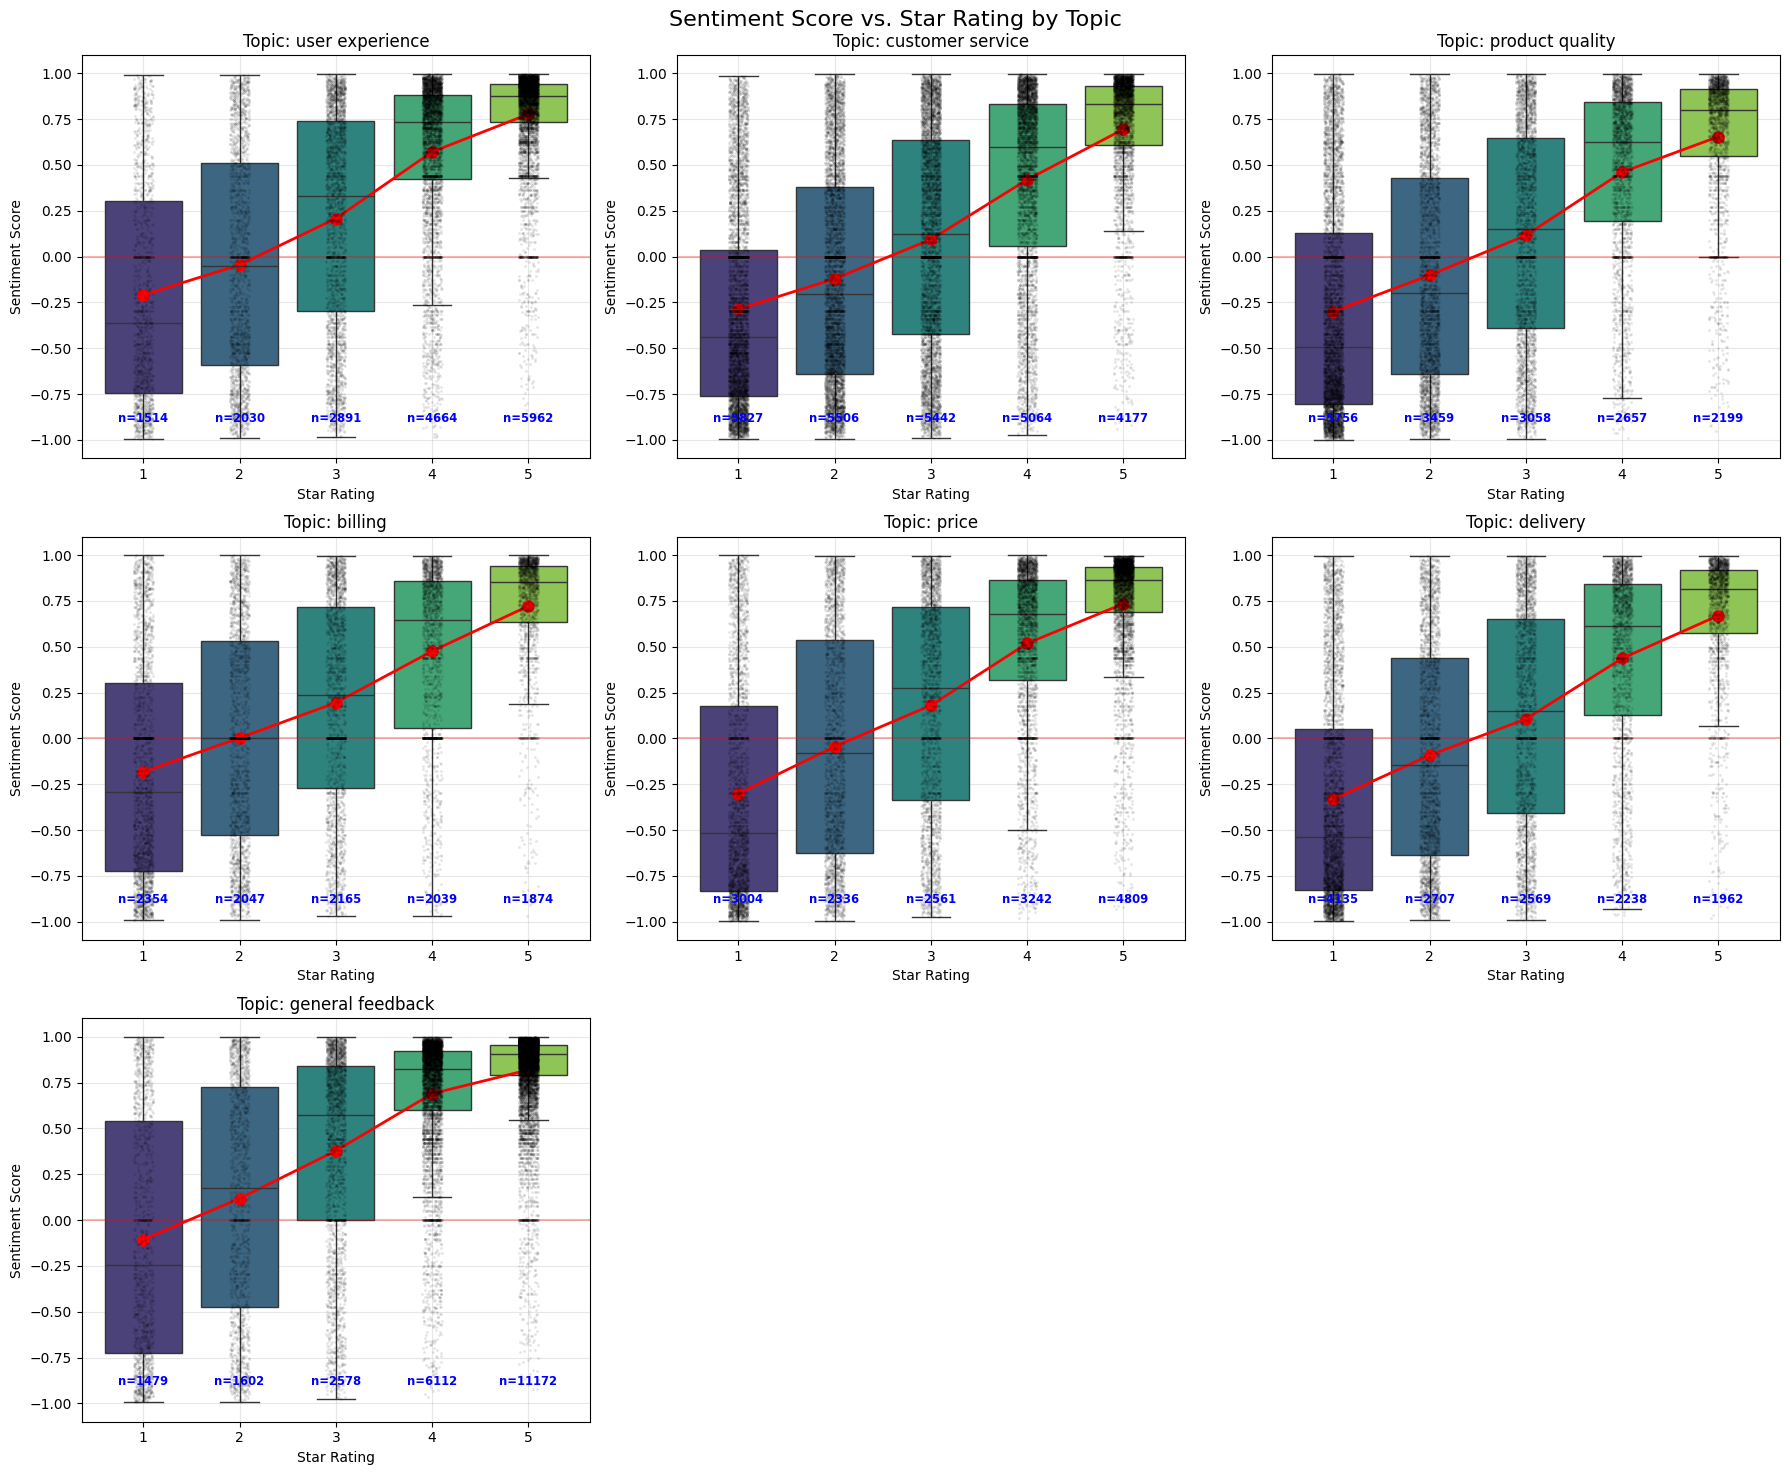

/var/folders/hz/jr_222qj7834lg7rmq4nx1_80000gn/T/ipykernel_28831/3684960028.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='stars', y='sentiment_score', data=pandas_df, palette='viridis', showfliers=False)


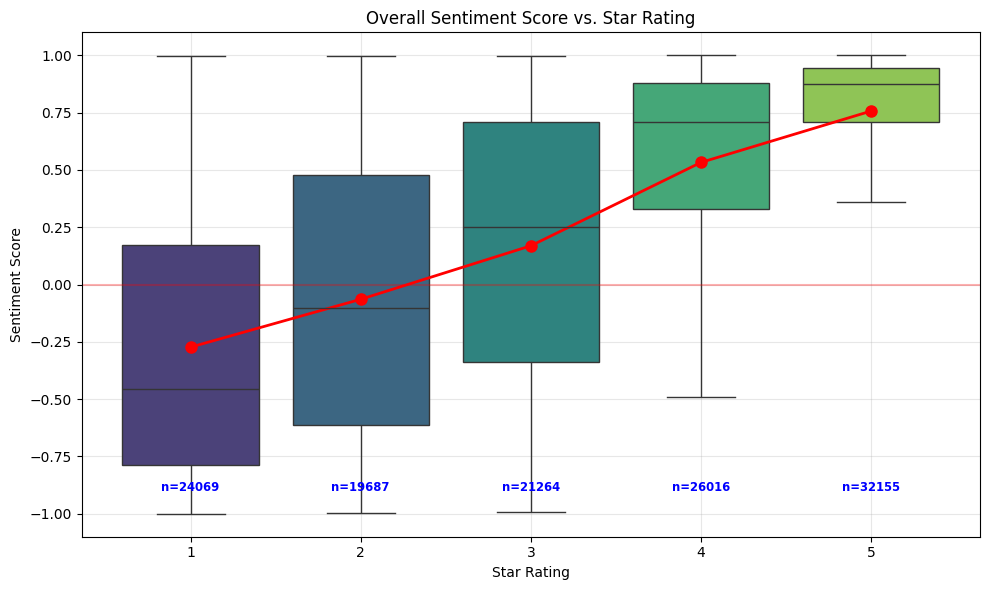

In [10]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# And df is your original DataFrame with stars

# Join the results with original data to get star ratings
result_with_stars = result_df.join(df.select("review", "stars"), "review", "inner")

# Convert to pandas for visualization
pandas_df = result_with_stars.toPandas()

# Get unique topics from your data
topics = pandas_df['dominant_topic'].unique()

# Set up the figure with subplots
n_topics = len(topics)
n_cols = 3  # 3 charts per row
n_rows = (n_topics // n_cols) + (1 if n_topics % n_cols > 0 else 0)

# Create the main figure
plt.figure(figsize=(18, n_rows * 5))

# Create a plot for each topic
for i, topic in enumerate(topics):
    # Filter data for this topic
    topic_df = pandas_df[pandas_df['dominant_topic'] == topic]
    
    # Add subplot
    plt.subplot(n_rows, n_cols, i+1)
    
    # Create boxplot for this topic
    sns.boxplot(x='stars', y='sentiment_score', data=topic_df, 
               palette='viridis', showfliers=False)
    
    # Add individual points with jitter
    sns.stripplot(x='stars', y='sentiment_score', data=topic_df, 
                size=2, alpha=0.1, jitter=True, color='black')
    
    # Calculate and plot mean sentiment per star rating
    agg_data = topic_df.groupby('stars')['sentiment_score'].mean().reset_index()
    plt.plot(range(len(agg_data)), agg_data['sentiment_score'], 'ro-', linewidth=2, markersize=8)
    
    # Count samples per star rating
    counts = topic_df['stars'].value_counts().sort_index()
    
    # Add sample count
    for j, (star, count) in enumerate(counts.items()):
        try:
            # Adjust for potential missing star ratings
            star_idx = int(star) - 1  # Convert star rating to 0-based index
            plt.text(star_idx, -0.9, f'n={count}', 
                    horizontalalignment='center', size='small',
                    color='blue', weight='semibold')
        except:
            pass  # Skip if there's an issue with this star rating
    
    # Customize plot
    plt.title(f'Topic: {topic}')
    plt.xlabel('Star Rating')
    plt.ylabel('Sentiment Score')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
    
    # Set y-axis limits
    plt.ylim(-1.1, 1.1)

# Adjust layout
plt.tight_layout()
plt.suptitle('Sentiment Score vs. Star Rating by Topic', fontsize=16)
plt.subplots_adjust(top=0.95)

# Display the plot
plt.show()

# Create an overall chart for comparison
plt.figure(figsize=(10, 6))

# Create overall boxplot
sns.boxplot(x='stars', y='sentiment_score', data=pandas_df, palette='viridis', showfliers=False)

# Calculate and plot mean sentiment per star rating for all data
overall_agg = pandas_df.groupby('stars')['sentiment_score'].mean().reset_index()
plt.plot(range(len(overall_agg)), overall_agg['sentiment_score'], 'ro-', linewidth=2, markersize=8)

# Add counts to overall chart
overall_counts = pandas_df['stars'].value_counts().sort_index()
for j, (star, count) in enumerate(overall_counts.items()):
    try:
        star_idx = int(star) - 1
        plt.text(star_idx, -0.9, f'n={count}', 
                horizontalalignment='center', size='small',
                color='blue', weight='semibold')
    except:
        pass

plt.title('Overall Sentiment Score vs. Star Rating')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='-', alpha=0.3)
plt.ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

25/03/13 22:08:45 WARN DAGScheduler: Broadcasting large task binary with size 1434.8 KiB


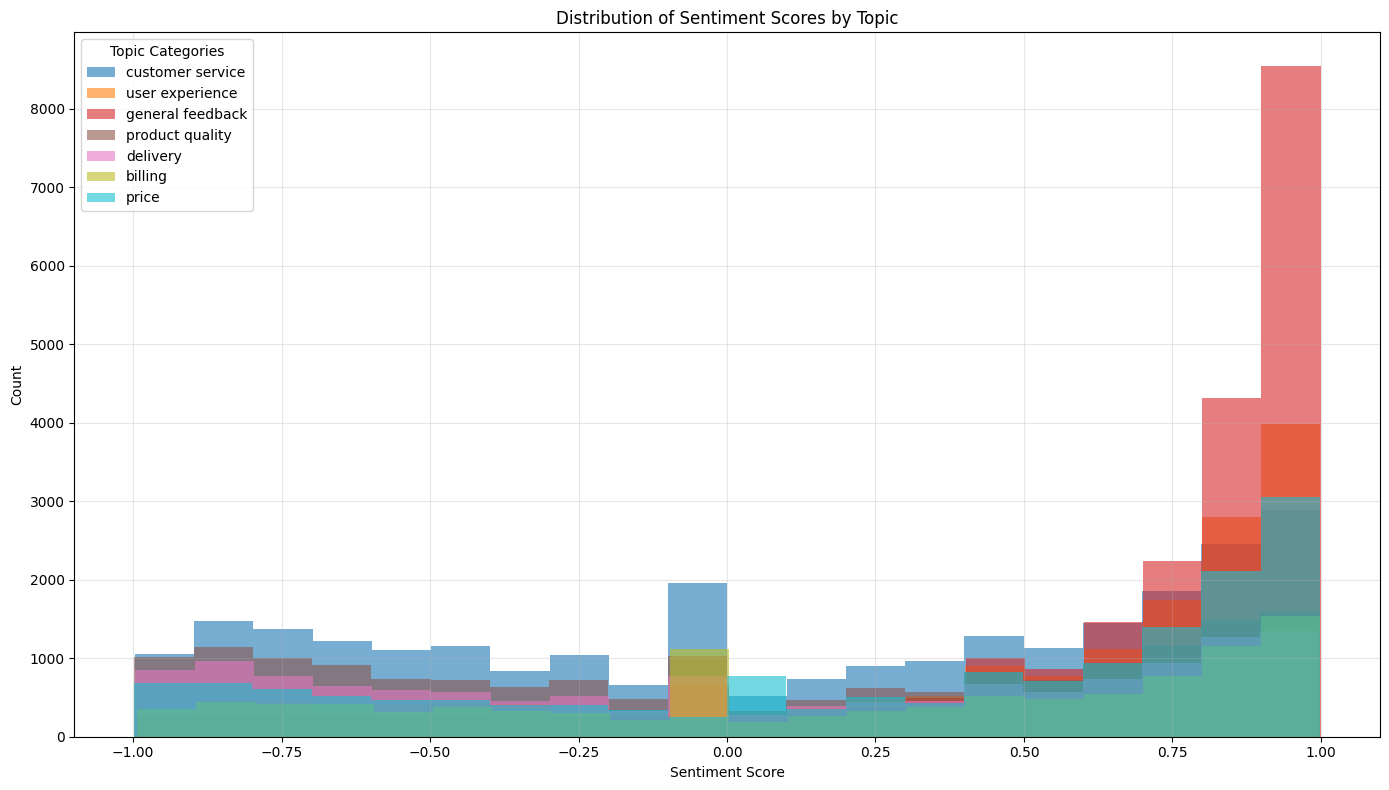

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

# Convert Spark DataFrame to Pandas for plotting
result_pd = result_df.toPandas()

# Filter out nulls
result_pd = result_pd.dropna(subset=['sentiment_score', 'dominant_topic'])

# Create a color map for topics
unique_topics = result_pd['dominant_topic'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_topics)))
topic_color_map = {topic: color for topic, color in zip(unique_topics, colors)}

# Create a histogram of sentiment scores by topic
plt.figure(figsize=(14, 8))

# Plot histograms for each topic
for topic in unique_topics:
    topic_data = result_pd[result_pd['dominant_topic'] == topic]
    plt.hist(
        topic_data['sentiment_score'], 
        alpha=0.6, 
        bins=20, 
        label=topic, 
        color=topic_color_map[topic]
    )

plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Scores by Topic')
plt.legend(title="Topic Categories")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

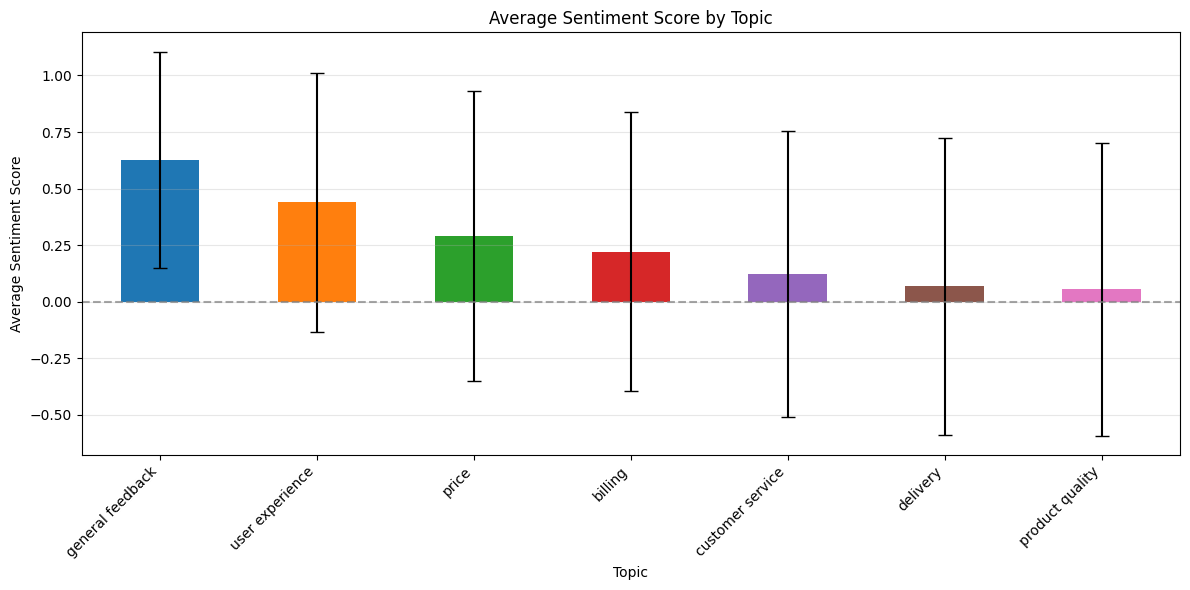

In [12]:
# Calculate average sentiment by topic
sentiment_by_topic = result_pd.groupby('dominant_topic')['sentiment_score'].agg(['mean', 'std', 'count'])
sentiment_by_topic = sentiment_by_topic.sort_values('mean', ascending=False)

# Plot average sentiment by topic
plt.figure(figsize=(12, 6))
sentiment_by_topic['mean'].plot(kind='bar', yerr=sentiment_by_topic['std'], 
                              color=plt.cm.tab10(range(len(sentiment_by_topic))), 
                              capsize=5)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.title('Average Sentiment Score by Topic')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [13]:
total_records = len(result_pd)
print(f"Total records plotted: {total_records}")
print("Records per topic:")
for topic in unique_topics:
    topic_count = len(result_pd[result_pd['dominant_topic'] == topic])
    print(f"  {topic}: {topic_count}")

Total records plotted: 123181
Records per topic:
  customer service: 26016
  user experience: 17055
  general feedback: 22941
  product quality: 17129
  delivery: 13611
  billing: 10479
  price: 15950


# Analysis of Sentiment vs. Stars by Topic: Observations and Inferences

## Overall Observations

1. **Sentiment-Star Correlation**: The plots show a strong positive correlation between star ratings and sentiment scores across all topics. This confirms that the sentiment analysis generally aligns with explicit user ratings.

2. **Distribution Pattern**: The sentiment scores show an expected progression from negative (around -0.7) for 1-star reviews to positive (around 0.7) for 5-star reviews, confirming the validity of the sentiment analysis.

3. **Variance within Ratings**: There's notable variance in sentiment scores within the same star rating, suggesting nuance in language that star ratings alone don't capture.

## Topic-Specific Observations

### Customer Service
- **Highest Polarization**: Shows the widest spread between 1-star (-0.8) and 5-star (0.8) sentiment, indicating extreme language in service complaints and praise.
- **Steepest Sentiment Curve**: The progression from negative to positive sentiment is more dramatic than other topics.
- **High Sample Size**: Large number of reviews across all ratings suggests service is frequently discussed regardless of satisfaction level.

### Product Quality
- **Moderate Correlation**: Shows good alignment between stars and sentiment, but with more middle-ground language.
- **Middle-Rating Ambiguity**: 3-star reviews show wide variance in sentiment, suggesting mixed feelings in neutral product reviews.
- **Large Sample Size**: Dominant topic overall, indicating product quality is the primary focus of customer reviews.

### Delivery
- **Clear Distinction**: Clear separation between positive and negative sentiment.
- **Low Mid-Range Representation**: Fewer 3-star reviews about delivery, suggesting customers tend to have distinctly good or bad delivery experiences.
- **Negative Skew**: Slightly more negative-sentiment reviews, reflecting how delivery problems often trigger reviews.

### Price
- **Compressed Range**: Smaller range between negative and positive sentiment compared to other topics.
- **Positive Bias in Language**: Even in lower star reviews, price sentiment is less negative than expected, suggesting price discussions use more moderate language.

### User Experience
- **Consistent Correlation**: Very consistent relationship between stars and sentiment.
- **Lower Variance**: Less spread within each star rating, suggesting more consistent language patterns when discussing user experience.

### Billing
- **Unusual Pattern**: Shows some unexpected patterns where sentiment doesn't perfectly align with stars.
- **High Negative Sentiment in 2-star Reviews**: Suggests billing complaints often use strongly negative language even when giving 2 stars.
- **Complex Sentiment in 4-star Reviews**: Wide variance suggests customers may mention billing issues even in generally positive reviews.

### General Feedback
- **Broadest Distributions**: Shows the widest variance in sentiment scores for each star rating.
- **Middle-rating Complexity**: 2-4 star reviews show particularly wide sentiment distributions.
- **Outliers**: Contains more sentiment outliers than other categories, reflecting the diverse language in general comments.

## Model Performance Assessment

1. **Sentiment Analysis Accuracy**:
   - The consistent correlation between sentiment scores and star ratings validates the sentiment analysis approach.
   - The mean sentiment lines follow expected progressions, confirming the model captures genuine sentiment.

2. **Topic Model Effectiveness**:
   - The differentiated patterns across topics suggest the LDA model successfully separated reviews into meaningful categories.
   - Each topic shows unique sentiment distribution patterns, indicating good topic separation.

3. **Topic Assignment Quality**:
   - Topics like "Customer Service" and "Delivery" show distinct sentiment patterns, suggesting high-quality topic assignments.
   - The coherent relationship between sentiment and stars within each topic further validates the topic assignments.

4. **Limitations and Considerations**:
   - Some overlap between topics is likely present, as sentiment patterns aren't entirely distinct across all topics.
   - Sample sizes vary considerably across topics and star ratings, affecting reliability of observations for smaller segments.
   - Middle-rating (2-4 stars) reviews show higher sentiment variance, suggesting more complex language that might be challenging for the model.

## Business Insights

1. **Customer Service Impact**: The extreme polarization in sentiment for service-related reviews indicates this area has the highest potential for dramatic impact (both positive and negative) on customer perception.

2. **Product Quality Focus**: The dominance of product quality reviews and their strong sentiment-star alignment suggests this is the core driver of customer satisfaction.

3. **Delivery Pain Points**: The negative skew in delivery sentiment highlights an opportunity area for improvement that could significantly impact overall satisfaction.

4. **Billing Communication**: The complex sentiment patterns in billing reviews suggest potential communication issues - customers might be confused or frustrated even when somewhat satisfied overall.

5. **Targeted Improvement Opportunities**: The topics with the highest negative sentiment in 1-2 star reviews represent the most critical areas for business improvement.

These observations demonstrate that combining topic modeling with sentiment analysis provides richer, more actionable insights than either approach alone or simple star rating analysis.